# Siamese Network with Optuna for Hyperparameter Optimization

### Install dependencies

In [1]:
%cd {HOME}

!python -m pip install opencv-python matplotlib tensorflow==2.10 

[WinError 2] 系統找不到指定的檔案。: '{HOME}'
e:\Code\CowId\notebooks


In [2]:
!conda install -c conda-forge cudatoolkit=11.8.0 --yes

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0




In [3]:
!pip install nvidia-cudnn-cu11==8.6.0.163 --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [4]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib

'CUDNN_PATH' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'export' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [5]:
# Check CPU
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(-566.9949, shape=(), dtype=float32)


2023-06-28 09:23:56.969128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 09:23:57.812393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# Check GPU
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!pip install optuna

### Import dependencies

In [1]:
import os
import cv2
import csv
import time
import random
import optuna
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import backend, layers, metrics, regularizers


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout


from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

e:\Code\CowId\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.10.0', '1.24.2')

### Set up environment

Set GPU growth to avoid OOM errors

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Set Home path

In [3]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

e:\Code\CowId


Set data path

In [4]:
dataset_path = os.path.join(HOME, "data", "siamese_v7_augmented/train_val")

In [5]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Helper functions

In [6]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [7]:
def generate_triplets(output_loc):
    if not os.path.exists(output_loc):
        os.makedirs(output_loc)
    triplets = []
    for cows in os.listdir(dataset_path):
        neg_dir_list = os.listdir(dataset_path)
        neg_dir_list.remove(cows)
        all_cows_except_current = []
        for neg_cows in neg_dir_list:
            neg_list = os.listdir(os.path.join(dataset_path, neg_cows))
            neg_list = list(map(lambda x: os.path.join(dataset_path, neg_cows, x), neg_list))
            all_cows_except_current = all_cows_except_current + neg_list
        path_to_cow = os.path.join(dataset_path, cows)
        print(path_to_cow)
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(dataset_path,cows))
            pos_list = list(map(lambda x: os.path.join(dataset_path, cows, x), pos_list))
            while len(pos_list) > 1 and len(neg_list) > 0:
                rand_pos_index = random.randrange(len(pos_list)) 
                positive_elem = pos_list.pop(rand_pos_index)
                rand_anc_index = random.randrange(len(pos_list))
                anchor_elem = pos_list.pop(rand_anc_index)
                rand_neg_index = random.randrange(len(neg_list))
                neg_elem = neg_list.pop(rand_neg_index)
                triplets.append((positive_elem,anchor_elem,neg_elem))  
    print(len(triplets))
    with open(os.path.join(output_loc, 'triplets.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in triplets:
            writer.writerow(row)

In [8]:
def split_dataset(saving_route, percentage=0.2):
    dataset = []
    with open(os.path.join(saving_route, 'triplets.csv'), newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            dataset.append(row)
    n = len(dataset)
    split_point = int(n * percentage)
    random.shuffle(dataset)
    train_set = dataset[:split_point] 
    test_set = dataset[split_point:]
    return train_set, test_set

In [9]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [10]:
# def get_encoder(input_shape):

#     pretrained_model = ResNet152(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )
    
#     for i in range(len(pretrained_model.layers)-12):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(1024, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

def get_encoder(input_shape):
    pretrained_model = ResNet152(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-12):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.5)),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.5)),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.5)),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [12]:
def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.5):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
def test_on_triplets(val_triplets, siamese_model, batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [15]:
def plot_metrics(loss, metrics, dir):
    plt.clf()
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Loss.png'))
    plt.clf()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Accuracy.png'))
    
    plt.figure(figsize=(15,5))
    plt.clf()
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()
    plt.savefig(os.path.join(dir, 'metrics.png'))
    plt.clf()

In [16]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

In [17]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [18]:
def ModelMetrics(pos_list, neg_list, dir):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig(os.path.join(dir, 'confusion_matrix.png'))
    plt.clf()
    return accuracy_score(true, pred), f1_score(true, pred)

In [19]:
def preprocess(img):
    img = tf.image.resize(img, (128,128))
    img = img / 255.0
    return img

In [20]:
def classify_image(encoder, cow1, cow2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array([cow1]))
    tensor2 = encoder.predict(np.array([cow2]))
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    return distance[0]

In [21]:
saving_route = os.path.join(HOME, 'data', 'siamese_triplets_lists')

# generate_triplets(saving_route)

In [22]:
train_triplets, val_triplets = split_dataset(saving_route, 0.2)

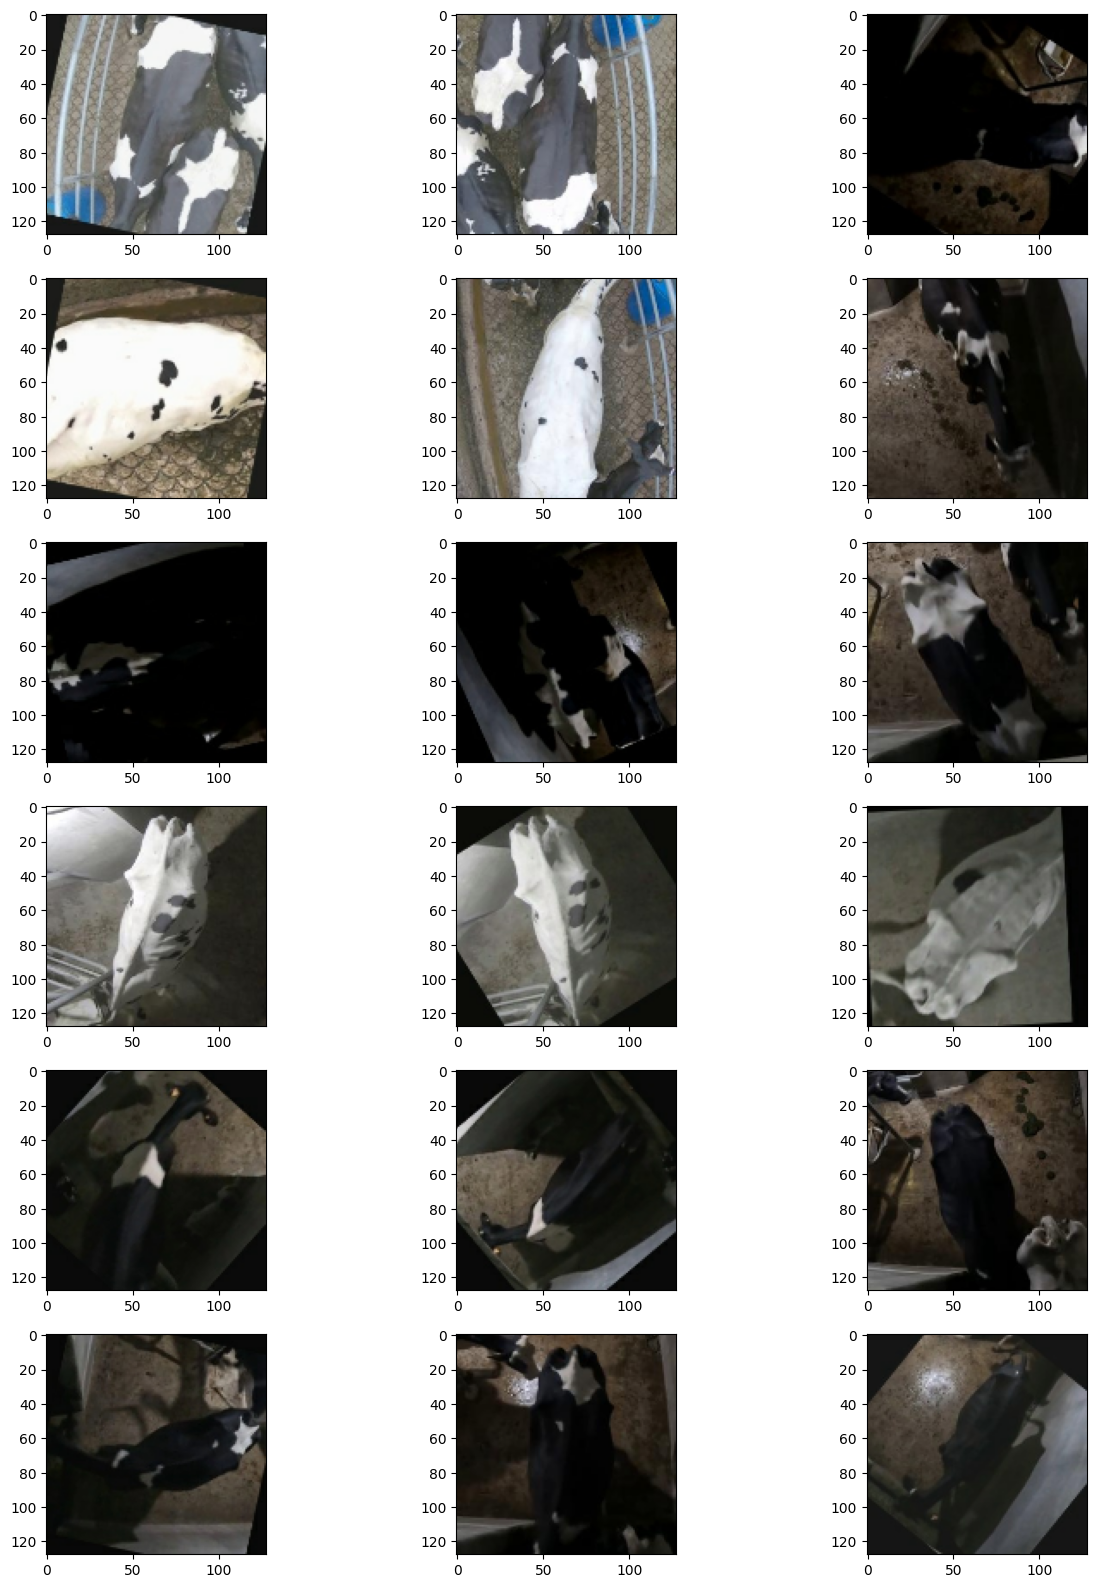

In [23]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False): # CHOCHE: Probar que da con true
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
    break

In [24]:
store_folder = 'optuna_siamese_resnet_v7'

folder_names = [int(name) for name in os.listdir(os.path.join(HOME, 'data', store_folder)) if os.path.isdir(os.path.join(HOME, 'data', store_folder, name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else sorted_folders[0]

def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', store_folder, str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(os.path.join(HOME, 'data', OPTUNA_DIR)):
        os.makedirs(os.path.join(HOME, 'data', OPTUNA_DIR))

    param_grid = {"LR": 3, # trial.suggest_int("LR", -5, -3, step=1), 
                  'E': 5, # trial.suggest_int("E", -4, -2, step=1), 
                  'EPOCHS': 30, # trial.suggest_int("EPOCHS", 20, 30, step=10),
                  'BATCH_SIZE': 64, # trial.suggest_int("BATCH_SIZE", 32, 32, step=32),
                #   'With one more layer dense 1024 and one batch norm': 2
                  }

    LR = 10**param_grid["LR"]
    E = 10**param_grid["E"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]

    save_all = False

    siamese_network = get_siamese_network()

    siamese_model = SiameseModel(siamese_network)

    optimizer = Adam(learning_rate=LR, epsilon=E)

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    siamese_model.compile(optimizer=optimizer)

    max_acc = 0
    train_loss = []
    test_metrics = []

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")
        
        # Training the model on train data
        epoch_loss = []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE):
            loss = siamese_model.train_on_batch(data)
            epoch_loss.append(loss)
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        train_loss.append(epoch_loss)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        
        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE) # CHOCHE: Como mierda esta testeando esto sin threshold??
        test_metrics.append(metric)
        accuracy = metric[0]
        
        # Saving the model weights
        if save_all or accuracy>=max_acc:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model"))
            max_acc = accuracy

    # Saving the model after all epochs run
    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final"))

    test_metrics = np.array(test_metrics)
    plot_metrics(train_loss, test_metrics, os.path.join(OPTUNA_DIR))
    # CHOCHE: Estas metricas corresponden con las graficas, si es asi, la grafica es realmente test acc?? Si es asi, por queee??

    encoder = extract_encoder(siamese_model)
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))

    pos_list = np.array([])
    neg_list = np.array([])

    for data in get_batch(val_triplets, batch_size=64):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, 0.3))  
        # CHOCHE: Por que este 0.3, esta es la distancia entre que es la misma vaca o no, pero este numero es arbitrario, soy consistente en los otros lugares?
        neg_list = np.append(neg_list, classify_images(encoder, a, n, 0.3))
    

    model_accuracy, model_f1 = ModelMetrics(pos_list, neg_list, os.path.join(OPTUNA_DIR))
    # CHOCHE: Esta porqueria, esta tomando datos diferentes a los del otro grafico, que tan bien esta? Puedo hacer el conf. matrix con los resultados del otro? 
    # O hacer graficas con estos resultados?

    encoder.save(os.path.join(OPTUNA_DIR, 'siamese_model.h5'))

    return model_accuracy, model_f1


In [27]:
# Select to maximize or minimize parameters
study = optuna.create_study(directions=['maximize', 'maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siamese_v13.db')}", load_if_exists=True)
study.optimize(objective, n_trials=1)

[I 2023-06-27 14:49:05,685] A new study created in RDB with name: no-name-3decd8a6-bfdf-4a1b-a866-98354957896e


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 62 sec)
Loss on train    = 0.47955
1/1 [==============================] - 5s 5s/step
Accuracy on test = 0.91932
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 39 sec)
Loss on train    = 0.16159
1/1 [==============================] - 0s 133ms/step
Accuracy on test = 0.95179
Started training EPOCH 3


[W 2023-06-27 15:00:20,699] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "e:\Code\CowId\.conda\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\arihs\AppData\Local\Temp\ipykernel_22944\2966130866.py", line 52, in objective
    loss = siamese_model.train_on_batch(data)
  File "e:\Code\CowId\.conda\lib\site-packages\keras\engine\training.py", line 2381, in train_on_batch
    logs = self.train_function(iterator)
  File "e:\Code\CowId\.conda\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "e:\Code\CowId\.conda\lib\site-packages\tensorflow\python\eager\def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "e:\Code\CowId\.conda\lib\site-packages\tensorflow\python\eager\def_function.py", line 947, in _call
    return self._statel

KeyboardInterrupt: 

[I 2023-07-12 18:31:05,305] A new study created in RDB with name: no-name-24d4c573-3854-4ad4-bba4-f4e4a391e36d


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 51 sec)
Loss on train    = 0.58648
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.86422
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 7 sec)
Loss on train    = 0.43862
1/1 [==============================] - 0s 48ms/step
Accuracy on test = 0.87307
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 7 sec)
Loss on train    = 0.35358
1/1 [==============================] - 0s 49ms/step
Accuracy on test = 0.94310
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 7 sec)
Loss on train    = 0.23966
1/1 [==============================] - 0s 39ms/step
Accuracy on test = 0.92588
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 7 sec)
Loss on train    = 0.22151
1/1 [==============================] - 0s 39ms/step
Accuracy on test = 0.94638
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 7 sec)
Loss on train    = 0.24323
1/1 [==============================] - 0s 51ms/step
Accuracy on test = 0.94818
Started tra

[I 2023-07-12 18:58:55,366] Trial 0 finished with values: [0.9042308953755329, 0.9102091020910209] and parameters: {}. 


<Figure size 640x480 with 0 Axes>

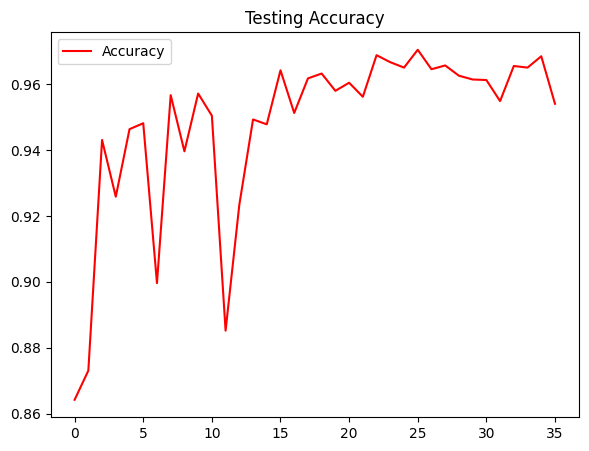

<Figure size 1500x500 with 0 Axes>

In [25]:
store_folder = 'optuna_siamese_resnet_v7'

folder_names = [int(name) for name in os.listdir(os.path.join(HOME, 'data', store_folder)) if os.path.isdir(os.path.join(HOME, 'data', store_folder, name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else sorted_folders[0]

def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', store_folder, str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(os.path.join(HOME, 'data', OPTUNA_DIR)):
        os.makedirs(os.path.join(HOME, 'data', OPTUNA_DIR))

    param_grid = {"LR": -3, # trial.suggest_int("LR", -5, -3, step=1), 
                  'E': -3, # trial.suggest_int("E", -4, -2, step=1), 
                  'EPOCHS': 50, # trial.suggest_int("EPOCHS", 20, 30, step=10),
                  'BATCH_SIZE': 32, # trial.suggest_int("BATCH_SIZE", 32, 32, step=32),
                   'With one more layer dense 1024 and one batch norm, and changed siamese architecture, \
                    and l2 of 0.8 instead of 0.5, changed dropout from 0.5 to 0.8, changed margin from 1.0 to 1.5 in siamese model': 2
                  }

    LR = 10**param_grid["LR"]
    E = 10**param_grid["E"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]

    save_all = False

    siamese_network = get_siamese_network()

    siamese_model = SiameseModel(siamese_network)

    optimizer = Adam(learning_rate=LR, epsilon=E)

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    siamese_model.compile(optimizer=optimizer)

    max_acc = 0
    train_loss = []
    test_metrics = []

        # add these lines before your training loop
    patience = 10 # Number of epochs to wait for improvement before stopping
    best_metric = -np.inf # This can be np.inf if the metric is something you want to minimize, like loss
    epochs_no_improve = 0 

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")
        
        # Training the model on train data
        epoch_loss = []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE):
            loss = siamese_model.train_on_batch(data)
            epoch_loss.append(loss)
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        train_loss.append(epoch_loss)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        
        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE)
        test_metrics.append(metric)
        accuracy = metric[0]
        
        # check if the current metric is better than the best seen so far
        if accuracy > best_metric:
            best_metric = accuracy
            epochs_no_improve = 0 # reset the counter
        else:
            epochs_no_improve += 1

        # if the metric didn't improve for 'patience' epochs, stop training
        if epochs_no_improve == patience:
            print(f'Early stopping: Model did not improve from {best_metric:.5f} for {patience} epochs')
            break

        # Saving the model weights
        if save_all or accuracy>=max_acc:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model"))
            max_acc = accuracy

    # Saving the model after all epochs run
    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final"))


    test_metrics = np.array(test_metrics)
    plot_metrics(train_loss, test_metrics, os.path.join(OPTUNA_DIR))

    encoder = extract_encoder(siamese_model)
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))

    pos_list = np.array([])
    neg_list = np.array([])

    for data in get_batch(val_triplets, batch_size=64):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, 0.3))
        neg_list = np.append(neg_list, classify_images(encoder, a, n, 0.3))

    model_accuracy, model_f1 = ModelMetrics(pos_list, neg_list, os.path.join(OPTUNA_DIR))

    encoder.save(os.path.join(OPTUNA_DIR, 'siamese_model.h5'))

    return model_accuracy, model_f1

# Select to maximize or minimize parameters
study = optuna.create_study(directions=['maximize', 'maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siamese_v13.db')}", load_if_exists=True)
study.optimize(objective, n_trials=1)


In [ ]:
# os.system("shutdown /s /t 1")

0

In [33]:
# Save the parameters
import pickle

# save the list to a file
with open(os.path.join(HOME, 'data', 'trials.pickle'), 'wb') as f:
    pickle.dump(study.best_trials, f)

## Prediction on test set

In [1]:
import csv
import os
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

from ultralytics import YOLO
from PIL import Image
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)

e:\Code\CowId


In [3]:

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [4]:
# CHOCHE: Al fin y al cabo, estoy haciendo el mismo preprocesamiento para training y para esto que testeo? 

def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [5]:
def classify_image(encoder, cow1, cow2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array([cow1]))
    tensor2 = encoder.predict(np.array([cow2]))
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    return distance[0]

In [6]:
def get_batch(tuples_list, batch_size=64, preprocess=True):
    batch_steps = len(tuples_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        comparison = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(tuples_list):
            a, c = tuples_list[j]
            anchor.append(read_image(a))
            comparison.append(read_image(c))
            j+=1
            
        anchor = np.array(anchor)
        comparison = np.array(comparison)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            comparison = preprocess_input(comparison)
        
        yield ([anchor, comparison])

In [7]:
def generate_pairs(output_loc, test_dataset_path):
    pos_pairs, neg_pairs = [], []
    for cows in os.listdir(test_dataset_path):
        neg_dir_list = os.listdir(test_dataset_path)
        neg_dir_list.remove(cows)
        all_cows_except_current = []
        for neg_cows in neg_dir_list:
            neg_list = os.listdir(os.path.join(test_dataset_path, neg_cows))
            neg_list = [os.path.join(test_dataset_path, neg_cows, x) for x in neg_list]
            all_cows_except_current += neg_list
        path_to_cow = os.path.join(test_dataset_path, cows)
        print(path_to_cow)
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(test_dataset_path, cows))
            pos_list = [os.path.join(test_dataset_path, cows, x) for x in pos_list]
            anchor_image = os.path.join(path_to_cow, 'anchor.jpg')
            pos_pairs += [(anchor_image, x) for x in pos_list if x != anchor_image]
            neg_pairs += [(anchor_image, x) for x in all_cows_except_current]
    print(len(pos_pairs), len(neg_pairs))
    with open(os.path.join(output_loc, 'pos_pairs.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in pos_pairs:
            writer.writerow(row)
    with open(os.path.join(output_loc, 'neg_pairs.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in neg_pairs:
            writer.writerow(row)


In [8]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [9]:
def save_params(params, filename):
    """Saves parameters to a json file"""
    with open(filename, 'w') as json_file:
        json.dump(params, json_file, indent=4)

In [10]:
def load_siamese_model(model_location):
    """Load a pre-trained model"""
    return tf.keras.models.load_model(
        os.path.join(model_location, 'siamese_model.h5'), 
        custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [11]:
def load_yolo_model(model_location):
    """Load a pre-trained model"""
    return YOLO(model_location)

In [12]:
def create_dir(base_folder, iteration):
    """Creates a new directory for storing data"""
    new_dir = os.path.join(HOME, 'data', base_folder, str(iteration))
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    return new_dir

In [13]:
def get_next_iteration(base_folder):
    """Determines the next iteration number based on existing directories"""
    folder_names = [
        int(name) for name in os.listdir(os.path.join(HOME, 'data', base_folder))
        if os.path.isdir(os.path.join(HOME, 'data', base_folder, name))
    ]
    return 0 if len(folder_names) == 0 else max(folder_names) + 1

In [14]:
def read_dataset(file_path):
    """Reads a dataset from a csv file and returns it as a list"""
    with open(file_path, newline='') as file:
        return list(csv.reader(file))

In [15]:
def classify_data(dataset, model, batch_size, threshold=0.5):
    """Classifies images using the siamese model"""
    result = np.array([])
    for data in get_batch(dataset, batch_size=batch_size):
        a, c = data
        result = np.append(result, classify_images(model, a, c, threshold))
    return result

In [16]:
def plot_confusion_matrix(true, pred, siamese_dir):
    """Computes and plots the confusion matrix"""
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig(os.path.join(siamese_dir, 'confusion_matrix.png'))
    plt.clf()

In [17]:
def expand_rectangle_to_square(x1, y1, x2, y2):
    width = abs(x2 - x1)
    height = abs(y2 - y1)
    size = max(width, height)
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    new_x1 = center_x - size / 2
    new_y1 = center_y - size / 2
    new_x2 = center_x + size / 2
    new_y2 = center_y + size / 2
    return new_x1, new_y1, new_x2, new_y2

In [18]:
def crop_to_square(image, x1, y1, x2, y2):
    cropped_image = Image.fromarray(image).crop((x1, y1, x2, y2)).resize((128, 128))
    return cropped_image

In [19]:
def verify(model, input_image, db_loc, detection_threshold):
    # Build results array
    best = detection_threshold
    cow = "None"
    numpy_array = np.array(input_image)
    input_img = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
    input_img = preprocess_input(input_img) 
    best_val_img = None
    
    for img_path in os.listdir(db_loc):
        image = cv2.imread(os.path.join(db_loc, img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        numpy_array = np.array(image)
        db_img = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
        # byte_img = tf.io.read_file(os.path.join(db_loc, image))
        # img = tf.io.decode_jpeg(byte_img)
        # img = tf.image.resize(img, [128, 128])
        # img = img / 255.0
        # / 255
        validation_img = preprocess_input(db_img) # / 255

        # fig, (ax1, ax2) = plt.subplots(ncols=2)
        # ax1.imshow(image)
        # ax2.imshow(input_image)
        # plt.savefig(os.path.join(HOME, 'data', img_path))
        # print("IMAGE TYPES")
        # print(type(input_img), type(validation_img))
        # print(input_img.shape, validation_img.shape)
        # return "", 0, "", ""
        # Make Predictions 
        distance = classify_image(model, input_img, validation_img)
        if distance < detection_threshold and distance < best:
            best = distance
            cow = img_path
            best_val_img = image
    # return None, None, None, None 
    return cow, best, input_image, best_val_img

In [20]:
def seconds_to_time(seconds):
    td = datetime.timedelta(seconds=seconds)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_str = f'{hours:02}:{minutes:02}:{seconds:02}'
    
    return time_str

In [21]:
print(os.listdir(os.path.join(HOME, "data", "siamese_v6_test", "test", "video_test")))

['anchor_1.jpg', 'anchor_2.jpg', 'anchor_3.jpg', 'anchor_4.jpg', 'anchor_5.jpg', 'anchor_6.jpg', 'anchor_7.jpg', 'anchor_8.jpg']


In [22]:
%%capture

params = {
    "STORE_FOLDER": "siamese_runs",
    "TEST_DATASET_PATH": os.path.join(HOME, "data", "siamese_v6_test", "test"),
    "SIAMESE_MODEL_LOC": os.path.join(HOME, "data", "optuna_siamese_resnet_v7", "49"),
    "YOLO_MODEL_LOC": os.path.join(HOME, "data", "yolo_models", "train11", "weights", "best.pt"),
    "VIDEO_INPUT_LOC": os.path.join(HOME, "data", 'videos_230305', "video_cc_1.mp4"),
    "VIDEO_TEST_COWS_LOC": os.path.join(HOME, "data", "siamese_v6_test", "test", "video_test"),
    "THRESHOLD": 0.005
}

siamese_model = load_siamese_model(params["SIAMESE_MODEL_LOC"])
yolo_model = load_yolo_model(params["YOLO_MODEL_LOC"])
siamese_run_iteration = get_next_iteration(params["STORE_FOLDER"])
siamese_dir = create_dir(params["STORE_FOLDER"], siamese_run_iteration)

def create_test_metrics():
    generate_pairs(siamese_dir, params["TEST_DATASET_PATH"])

    save_params(params, os.path.join(siamese_dir, "params.json"))

    pos_dataset = read_dataset(os.path.join(siamese_dir, "pos_pairs.csv"))
    neg_dataset = read_dataset(os.path.join(siamese_dir, "neg_pairs.csv"))

    pos_list = classify_data(pos_dataset, siamese_model, batch_size=256, threshold=params["THRESHOLD"])
    neg_list = classify_data(neg_dataset, siamese_model, batch_size=64, threshold=params["THRESHOLD"])

    # Calculate overall accuracy
    true_overall = np.array([0]*len(pos_list) + [1]*len(neg_list))
    pred_overall = np.append(pos_list, neg_list)
    print(f"Accuracy of model overall: {accuracy_score(true_overall, pred_overall)}")

    # Calculate accuracy for positives
    true_pos = np.array([0]*len(pos_list))
    print(f"Accuracy of model on positives: {accuracy_score(true_pos, pos_list)}")

    # Calculate accuracy for negatives
    true_neg = np.array([1]*len(neg_list))
    print(f"Accuracy of model on negatives: {accuracy_score(true_neg, neg_list)}")

    # Plot confusion matrix
    plot_confusion_matrix(true_overall, pred_overall, siamese_dir)

def create_video_pipiline_results():
    vidcap = cv2.VideoCapture(params["VIDEO_INPUT_LOC"])
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    success = True
    count = 0
    detections = []
    while success:
        success,image = vidcap.read()
        count += 1
        if count % 2 == 0: continue
        image = np.uint8(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        res = yolo_model(image, conf=0.5)
        boxes = res[0].boxes.xyxy.tolist()
        cow_number = 0
        for inner_list in boxes:
            cow_number += 1
            x1, y1, x2, y2 = inner_list
            x1, y1, x2, y2 = expand_rectangle_to_square(x1, y1, x2, y2)
            cropped_image = crop_to_square(image, x1, y1, x2, y2)
            verified_result, distance, cow_a, cow_b = verify(siamese_model, 
                                                             cropped_image, 
                                                             params["VIDEO_TEST_COWS_LOC"], 
                                                             params["THRESHOLD"])
            if verified_result != "None":
                time = seconds_to_time(count/fps)
                detection = f"{verified_result.split('.', 1)[0]} detected at time {time} with distance of {distance}"
                detections.append(detection)
                print(detection)

                fig, (ax1, ax2) = plt.subplots(ncols=2)
                ax1.imshow(cow_a)
                ax2.imshow(cow_b)
                plt.savefig(os.path.join(siamese_dir, f'{time.replace(":", "")}-{distance}.png'))
        
    with open(os.path.join(siamese_dir, 'detection_data.csv'), 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for row in detections:
            writer.writerow([row])
    return

create_video_pipiline_results()
create_test_metrics()


0: 384x640 (no detections), 80.0ms
Speed: 8.0ms preprocess, 80.0ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 21.0ms
Speed: 1.0ms preprocess, 21.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 53.1ms
Speed: 1.0ms preprocess, 53.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inferenc

In [7]:
os.listdir(os.path.join('..', 'data', 'optuna_siamese_resnet'))

['1',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '5',
 '6',
 '7',
 '8',
 '9']

In [8]:
import tensorflow as tf
import os
from tensorflow.keras.utils import plot_model
model = tf.keras.models.load_model(os.path.join('..', 'data', 'optuna_siamese_resnet_v7', '4', 'siamese_model.h5'), compile=False)
from tensorflow.keras.callbacks import TensorBoard

# Load your model. For instance:
# model = tf.keras.models.load_model('path_to_your_model')

# Provide the log directory to store your graph, histogram, etc.
log_dir = "logs/fit"

# Pass the TensorBoard callback to your model
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
file_writer = tf.summary.create_file_writer(log_dir)
with file_writer.as_default():
  tf.summary.graph(tf.get_default_graph(), step=0)


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [23]:
model = tf.keras.models.load_model(os.path.join('..', 'data', 'optuna_siamese_resnet_v7', '49', 'siamese_model.h5')) 
model.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                      

In [2]:
import tensorflow as tf
import os

model = tf.keras.models.load_model(os.path.join('..', 'data', 'optuna_siamese_resnet_v7', '49', 'siamese_model.h5')) 
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

TypeError: plot_model() got an unexpected keyword argument 'show_trainable'